No. characters vs accuracy
Brute_old [(1.0, 99.0, 1.7243221069147905), (2.0, 81.0, 6.562205878182604), (3.0, 24.0, 7.720062527732451), (4.0, 2.0, 2.282893712747859), (5.0, 0.0, 0.0)]
Vlute$_\infty$ [(1.0, 76.0, 6.945555555555557), (2.0, 5.0, 5.249891974197253), (3.0, 0.0, 0.0), (4.0, 0.0, 0.0), (5.0, 0.0, 0.0)]
Vlute$_{1000}$ [(1.0, 62.0, 3.7279498221600584), (2.0, 3.0, 3.6601221476615327), (3.0, 0.0, 0.0), (4.0, 0.0, 0.0), (5.0, 0.0, 0.0)]
Vlute$_{3000}$ [(1.0, 78.0, 6.214444444444445), (2.0, 3.0, 2.3191900060043844), (3.0, 0.0, 0.0), (4.0, 0.0, 0.0), (5.0, 0.0, 0.0)]
Vlute$_{5000}$ [(1.0, 64.0, 8.182240705513555), (2.0, 3.0, 2.591322235061847), (3.0, 0.0, 0.0), (4.0, 0.0, 0.0), (5.0, 0.0, 0.0)]
Vlute$_{10000}$ [(1.0, 76.0, 8.658343653079081), (2.0, 8.0, 3.448644213829581), (3.0, 0.0, 0.0), (4.0, 0.0, 0.0), (5.0, 0.0, 0.0)]
Vlute$_{15000}$ [(1.0, 80.0, 2.5848681223374905), (2.0, 3.0, 3.4727777777777784), (3.0, 0.0, 0.0), (4.0, 0.0, 0.0), (5.0, 0.0, 0.0)]
Vlute$_{30000}$ [(1.0, 78.0, 5

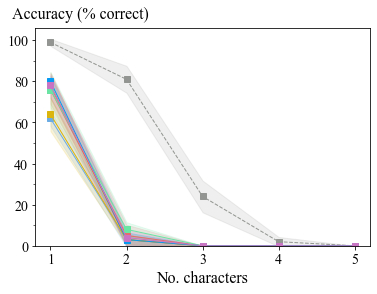

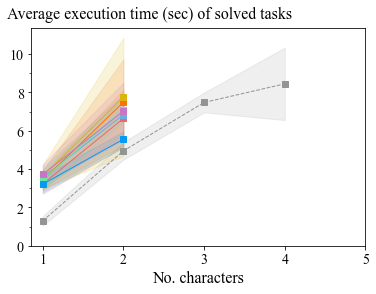

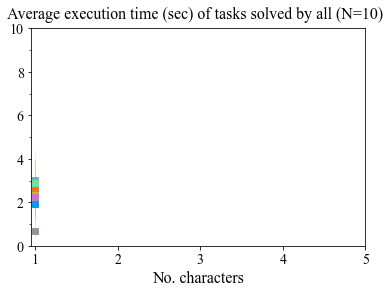

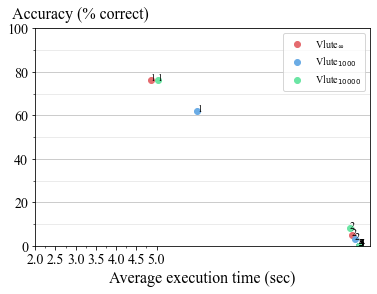

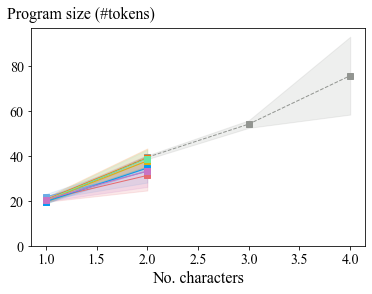

In [20]:
import json
import os
from collections import Callable
from math import sqrt
import matplotlib.pyplot as plt

class Results:
    def __init__(self, data, colors):
        self.results = [Result(d["file"], d["name"], colors[d["name"]]) for d in data]

    def filter_fields(self, fields: list[str]):
        for r in self.results:
            r.filter_fields(fields)

    def aggregate(self, over: str):
        for r in self.results:
            r.aggregate(over)

    def aggregate_multiple(self, over: list[str]):
        for r in self.results:
            r.aggregate_multiple(over)

    def aggregate_std(self, over: str, std_field: str):
        for r in self.results:
            r.aggregate_std(over, std_field)

    def flatten(self):
        for r in self.results:
            r.flatten()

    def filter(self, field: str, cond: Callable[[object], bool]):
        for r in self.results:
            r.filter(field, cond)

    def filter_all(self, id_field: str, field: str, cond: Callable[[object], bool]):

        d = {}
        for r in self.results:
            for e in r.results:
                if e[id_field] not in d:
                    d[e[id_field]] = []

                if cond(Result._field_parser(e, field)):
                    d[e[id_field]].append(e)

        l = len(self.results)
        for i in range(0, l):
            self.results[i].results = [v[i] for k, v in d.items() if len(v) == l]

    def _make_up(self, ax, x_axis, y_axis):
        plt.rcParams["font.family"] = "Times New Roman"

        ax.set_ylim(bottom=0)
        plt.xlabel(x_axis, fontsize=16)
        plt.ylabel(y_axis, fontsize=16, rotation="horizontal", horizontalalignment="left")
        ax.yaxis.set_label_coords(-0.07,1.1)
        ax.yaxis.set_label_position('right')
        ax.tick_params(axis='both', which='major', labelsize=14)
        #plt.title(title, fontsize=16)

        #plt.legend()

    def plot(self, x: Callable, y: Callable, title: str = "", x_axis: str = "", y_axis: str = ""):
        print(title)

        fig, ax = plt.subplots()

        for r in self.results:
            r.plot(ax, x, y)

        self._make_up(ax, x_axis, y_axis)

    def plot_errorbar(self, x: Callable, y: Callable, e: Callable = lambda _: 0, title: str = "", x_axis: str = "", y_axis: str = "", y_ticks = [], y_ticks_minor = [], x_ticks = [], x_ticks_minor = []):
        print(title)

        fig, ax = plt.subplots()

        for r in self.results:
            r.plot_errorbar(ax, x, y, e)

        if y_ticks:
            ax.set_yticks(y_ticks)

        if y_ticks_minor:
            ax.set_yticks(y_ticks_minor, minor=True)

        if x_ticks:
            ax.set_xticks(x_ticks)

        if x_ticks_minor:
            ax.set_xticks(x_ticks_minor, minor=True)

        self._make_up(ax, x_axis, y_axis)

    def scatter_plot(self, x: Callable, y: Callable, label: Callable, title: str = "", x_axis: str = "", y_axis: str = "", y_ticks = [], y_ticks_minor = [], x_ticks = [], x_ticks_minor = []):
        print(title)

        fig, ax = plt.subplots()

        for r in self.results:
            r.scatter_plot(x, y, label, ax)

        if y_ticks:
            ax.set_yticks(y_ticks)

        if y_ticks_minor:
            ax.set_yticks(y_ticks_minor, minor=True)

        if x_ticks:
            ax.set_xticks(x_ticks)

        if x_ticks_minor:
            ax.set_xticks(x_ticks_minor, minor=True)

        self._make_up(ax, x_axis, y_axis)

        plt.legend()


    def histogram(self, x: Callable, bins, title: str = "", x_axis: str = "", y_axis: str = ""):
        for r in self.results:
            r.histogram(x, bins)

    def save(self, question: int, domain: str, name: str):
        folder = "{}/Q{}/graphs/{}".format(os.getcwd(), question, domain)

        if not os.path.exists(folder):
            os.makedirs(folder)

        plt.savefig("{}/{}.pdf".format(folder, name), bbox_inches='tight')

class Result:
    def __init__(self, file_name, name, color):
        self.name = name
        self.color = color

        self.results = []

        with open(file_name, "r") as file:
            for line in file:
                stripped_line = line.strip()
                obj = json.JSONDecoder().decode(stripped_line)
                self.results.append(obj)

    def filter_fields(self, fields: list[str]):
        for i, res in enumerate(self.results):
            self.results[i] = {f: self._field_parser(res, f) for f in fields}

    @staticmethod
    def _field_parser(obj, field):
        if field == "complexity":
            return int(obj["file"].split("/")[1].split("-")[0])

        if field == "file_tuple":
            a = obj["file"].split("/")[1][:-3].split("-")
            return int(a[0]), int(a[1]), int(a[2])

        if field == "task":
            a = obj["file"].split("/")[1][:-3].split("-")
            return int(a[1])

        if field == "trial":
            a = obj["file"].split("/")[1][:-3].split("-")
            return int(a[2])

        if field == "correct":
            return 100 if obj["test_cost"] == obj["train_cost"] == 0 else 0

        if field == "zero_train_cost":
            return 1 if obj["train_cost"] == 0 else 0

        if field == "overfitted":
            return 1 if obj["test_cost"] > 0 and obj["train_cost"] == 0 else 0

        if field == "explored_per_sec":
            return obj["number_of_explored_programs"] / obj["execution_time"]

        if field == "average_explored_size_tokens":
            a = obj["explored_per_size_tokens"]
            return sum([a*b for a,b in enumerate(a)]) / sum(a)

        if field == "average_explored_size_sequence":
            a = obj["explored_per_size_sequence"]
            return sum([a*b for a,b in enumerate(a)]) / sum(a)

        if field in obj:
            return obj[field]

        raise Exception()

    def aggregate(self, over: str):
        final = {}

        for res in self.results:
            key = res[over]

            if key not in final:
                final[key] = {"dict": res, "count": 1}
            else:
                final[key]["count"] += 1
                for f in res:
                    final[key]["dict"][f] += res[f]

        for key, value in final.items():
            final[key] = {k: value["dict"][k] / value["count"] for k, v in value["dict"].items()}

        self.results = final

    def aggregate_multiple(self, fields: list[str]):
        final = {}

        for res in self.results:
            key = tuple([res[field] for field in fields])

            if key not in final:
                final[key] = {"dict": res, "count": 1}
            else:
                final[key]["count"] += 1
                for f in res:
                    final[key]["dict"][f] += res[f]

        for key, value in final.items():
            final[key] = {k: value["dict"][k] / value["count"] for k, v in value["dict"].items()}

        self.results = final

    def aggregate_std(self, over: str, std_field: str):
        final = {}

        for res in self.results:
            key = res[over]

            if key not in final:
                final[key] = {"dict": res, "count": 1, "values": []}
            else:
                final[key]["count"] += 1
                final[key]["values"].append(res[std_field])
                for f in res:
                    final[key]["dict"][f] += res[f]

        for key, value in final.items():
            final[key] = {k: value["dict"][k] / value["count"] for k, v in value["dict"].items()}

            total = sum([pow(v - final[key][std_field], 2) for v in value["values"]])
            std = sqrt(total / len(value["values"]))
            ci = 1.645 * std / sqrt(len(value["values"]))
            final[key]["std"] = ci

        self.results = final

    def flatten(self):
        self.results = [self.results[r] for r in self.results]

    def filter(self, field: str, cond: Callable[[object], bool]):
        result = []

        for res in self.results:
            if cond(self._field_parser(res, field)):
                result.append(res)

        self.results = result

    def plot(self, ax, x: Callable, y: Callable):
        xs = [x(r) for r in self.results.items()]
        ys = [y(r) for r in self.results.items()]
        yrs =  [y.__round__(3) for y in ys]
        print(self.name, list(zip(xs, yrs)))

        ax.plot(
            xs, ys,
            label=self.name,
            marker='o',
            color=self.color,
        )

    def plot_errorbar(self, ax, x: Callable, y: Callable, e: Callable = lambda _: 0):
        xs = [x(r) for r in self.results.items()]
        ys = [y(r) for r in self.results.items()]
        es = [e(r) for r in self.results.items()]
        ci1 = [y(r) - e(r) for r in self.results.items()]
        ci2 = [y(r) + e(r) for r in self.results.items()]
        yrs =  [y.__round__(3) for y in ys]
        print(self.name, list(zip(xs, yrs, es)))

        linestyle = "solid"
        if "Brute" in self.name:
            linestyle = "dashed"

        ax.errorbar(
            xs, ys,
            label=self.name,
            marker='s',
            ms=6,
            color=self.color,
            capsize=5,
            linestyle=linestyle,
            linewidth=1,
        )

        ax.fill_between(
            xs, ci1, ci2,
            color=self.color,
            alpha=0.15,
        )

    def scatter_plot(self, x: Callable, y: Callable, label: Callable, ax):
        xs = [x(r) for r in self.results.items()]
        ys = [y(r) for r in self.results.items()]
        xrs =  [x.__round__(5) for x in xs]
        yrs =  [y.__round__(5) for y in ys]
        print(self.name, list(zip(xrs, yrs)))

        ax.scatter(
                xs, ys,
                label=self.name,
                marker='o',
                color=self.color,
        )

        labels = [label(r) for r in self.results.items()]

        for x, y, l in zip(xs, ys, labels):
            ax.annotate(l, (x, y))

        plt.legend()
        plt.grid(axis="y", alpha=0.8)
        plt.grid(axis="y", which="minor", alpha=0.3)

    def histogram(self, x: Callable, bins, title: str = "", x_axis: str = "", y_axis: str = ""):
        xs = [x(r) for r in self.results]

        plt.hist(
            xs,
            bins=bins,
        )

        plt.xlabel(x_axis)
        plt.ylabel(y_axis)
        plt.title(title)

    def __str__(self):
        return self.results.__str__()

domain = "pixel"
colors = {
    "Brute_old": "xkcd:gray",
    "Brute_ni": "xkcd:gray",
    "Brute_ifs": "xkcd:gray",
    "Brute_no_ifs": "xkcd:gray",
    "Vlute$_\infty$": "#E56B6F",
    "Vlute$_{1000}$": "#6BACE5",
    "Vlute$_{3000}$": "xkcd:orange",
    "Vlute$_{5000}$": "xkcd:gold",
    "Vlute$_{10000}$": "#6BE5A4",
    "Vlute$_{15000}$": "xkcd:azure",
    "Vlute$_{30000}$": "xkcd:orchid",
}
data = {
    "robot": [
        {"name": "Brute_old", "file": "../results/hpc/Q1_robot/Brute.txt"},
        {"name": "Vlute$_\infty$", "file": "../results/hpc/Q1_robot/LNS.txt"},
        {"name": "Vlute$_{1000}$", "file": "../results/hpc/Q1_robot/VDNS_1000.txt"},
        #{"name": "Vlute$_{3000}$", "file": "../results/hpc/Q1_robot/VDNS_3000.txt"},
        #{"name": "Vlute$_{5000}$", "file": "../results/hpc/Q1_robot/VDNS_5000.txt"},
        {"name": "Vlute$_{10000}$", "file": "../results/hpc/Q1_robot/VDNS_10000.txt"},
        #{"name": "Vlute$_{15000}$", "file": "../results/hpc/Q1_robot/VDNS_15000.txt"},
        #{"name": "Vlute$_{30000}$", "file": "../results/hpc/Q1_robot/VDNS_30000.txt"},
    ], "string": [
        {"name": "Brute_old", "file": "../results/hpc/Q1_string/Brute_improved.txt"},
        #{"name": "Brute_ni", "file": "../results/hpc/Q1_string/Brute_ni.txt"},
        #{"name": "Brute_ifs", "file": "../results/hpc/Q1_string/Brute_ifs.txt"},
        #{"name": "Brute_no_ifs", "file": "../results/hpc/Q1_string/Brute_no_ifs.txt"},
        {"name": "Vlute$_\infty$", "file": "../results/hpc/Q1_string/LNS.txt"},
        {"name": "Vlute$_{1000}$", "file": "../results/hpc/Q1_string/VDNS_1000.txt"},
        {"name": "Vlute$_{3000}$", "file": "../results/hpc/Q1_string/VDNS_3000.txt"},
        {"name": "Vlute$_{5000}$", "file": "../results/hpc/Q1_string/VDNS_5000.txt"},
        {"name": "Vlute$_{10000}$", "file": "../results/hpc/Q1_string/VDNS_10000.txt"},
        {"name": "Vlute$_{15000}$", "file": "../results/hpc/Q1_string/VDNS_15000.txt"},
        {"name": "Vlute$_{30000}$", "file": "../results/hpc/Q1_string/VDNS_30000.txt"},
    ], "pixel": [
        {"name": "Brute_old", "file": "../results/hpc/Q1_pixel/Brute.txt"},
        {"name": "Vlute$_\infty$", "file": "../results/hpc/Q1_pixel/LNS.txt"},
        {"name": "Vlute$_{1000}$", "file": "../results/hpc/Q1_pixel/VDNS_1000.txt"},
        {"name": "Vlute$_{3000}$", "file": "../results/hpc/Q1_pixel/VDNS_3000.txt"},
        {"name": "Vlute$_{5000}$", "file": "../results/hpc/Q1_pixel/VDNS_5000.txt"},
        {"name": "Vlute$_{10000}$", "file": "../results/hpc/Q1_pixel/VDNS_10000.txt"},
        {"name": "Vlute$_{15000}$", "file": "../results/hpc/Q1_pixel/VDNS_15000.txt"},
        {"name": "Vlute$_{30000}$", "file": "../results/hpc/Q1_pixel/VDNS_30000.txt"},
]}[domain]
complexity = {
    "robot": "Grid size",
    "string": "No. examples",
    "pixel": "No. characters",
}[domain]


#"""     Complexity vs accuracy
results = Results(data, colors)
results.filter_fields(["complexity", "correct", "trial"])
results.aggregate_multiple(["complexity", "trial"])
results.flatten()
results.aggregate_std("complexity", "correct")
results.plot_errorbar(
    x=lambda t: t[0],
    y=lambda t: t[1]["correct"],
    e=lambda t: t[1]["std"],
    title="{} vs accuracy".format(complexity),
    x_axis=complexity,
    y_axis="Accuracy (% correct)",
    y_ticks=[0, 20, 40, 60, 80, 100],
    y_ticks_minor=[10, 30, 50, 70, 90],
    x_ticks={
        "string": range(1, 10),
        "pixel": range(1, 6),
        "robot": range(2, 12, 2),
    }[domain],
)
results.save(1, domain, "complexity_vs_accuracy")
#"""

# Complexity vs average execution time (of correct)
results = Results(data, colors)
results.filter("correct", lambda v: v == 100)
results.filter_fields(["complexity", "execution_time", "trial", "task"])
results.aggregate_multiple(["complexity", "trial", "task"])
results.flatten()
results.aggregate_std("complexity", "execution_time")
results.plot_errorbar(
    x=lambda t: t[0],
    y=lambda t: t[1]["execution_time"],
    e=lambda t: t[1]["std"],
    title="{} vs execution time of solved problems".format(complexity),
    x_axis=complexity,
    y_axis="Average execution time (sec) of solved tasks",
    y_ticks={
        "string": [0, 0.5, 1, 1.5, 2],
        "robot": [0, 0.5, 1, 1.5],
        "pixel": [0, 2, 4, 6, 8, 10],
        }[domain],
    y_ticks_minor={
        "string": [0.25, 0.75, 1.25, 1.75],
        "robot": [0.25, 0.75, 1.25],
        "pixel": [1, 3, 5, 7, 9],
    }[domain],
    x_ticks={
        "string": range(1, 10),
        "pixel": range(1, 6),
        "robot": range(2, 12, 2),
    }[domain],
)
results.save(1, domain, "complexity_vs_execution_time_correct")

# Complexity vs average execution time (of correct)
results = Results(data, colors)
results.filter_all("file", "correct", lambda v: v == 100)
n = len(results.results[0].results)
n0 = len({r["file"].split("/")[1][:-3].split("-")[1] for r in results.results[0].results})
results.filter_fields(["complexity", "execution_time", "trial"])
results.aggregate_multiple(["complexity", "trial"])
results.flatten()
results.aggregate_std("complexity", "execution_time")
results.plot_errorbar(
    x=lambda t: t[0],
    y=lambda t: t[1]["execution_time"],
    e=lambda t: t[1]["std"],
    title="{} vs execution time of solved problems".format(complexity),
    x_axis=complexity,
    y_axis="Average execution time (sec) of tasks solved by all (N={})".format(n0),
    y_ticks={
        "string": [0, 0.5, 1, 1.5, 2],
        "robot": [0, 0.5, 1, 1.5],
        "pixel": [0, 2, 4, 6, 8, 10],
        }[domain],
    y_ticks_minor={
        "string": [0.25, 0.75, 1.25, 1.75],
        "robot": [0.25, 0.75, 1.25],
        "pixel": [1, 3, 5, 7, 9],
    }[domain],
    x_ticks={
        "string": range(1, 10),
        "pixel": range(1, 6),
        "robot": range(2, 12, 2),
    }[domain],
)
results.save(1, domain, "complexity_vs_execution_time_all_correct")

# Per complexity (execution time, accuracy)
results = Results([d for d in data if d["name"] in {"Brute", "Vlute$_\infty$", "Vlute$_{1000}$", "Vlute$_{10000}$"}], colors)
results.filter_fields(["complexity", "execution_time", "correct"])
results.aggregate("complexity")
results.scatter_plot(
    x=lambda t: t[1]["execution_time"],
    y=lambda t: t[1]["correct"],
    label=lambda t: int(t[1]["complexity"]),
    title="Accuracy and average execution time per {}".format(complexity.lower()),
    y_axis="Accuracy (% correct)",
    x_axis="Average execution time (sec)",
    y_ticks=[0, 20, 40, 60, 80, 100],
    y_ticks_minor=[10, 30, 50, 70, 90],
    x_ticks=[2, 2.5, 3, 3.5, 4, 4.5, 5],
    x_ticks_minor=[2.25, 2.75, 3.25, 3.75, 4.25, 4.75],
)
results.save(1, domain, "exe_time_and_accuracy_per_complexity")

# Complexity vs program length (of correct)
results = Results(data, colors)
results.filter("correct", lambda v: v == 100)
results.filter_fields(["complexity", "program_length", "trial"])
results.aggregate_multiple(["complexity", "trial"])
results.flatten()
results.aggregate_std("complexity", "program_length")
results.plot_errorbar(
    x=lambda t: t[0],
    y=lambda t: t[1]["program_length"],
    e=lambda t: t[1]["std"],
    title="{} vs program length (of correct)".format(complexity),
    x_axis=complexity,
    y_axis="Program size (#tokens)",
)
results.save(1, domain, "complexity_vs_program_length_of_correct")

if domain == "robot" or domain == "string":
    #"""     Complexity vs search depth
    results = Results([d for d in data if "Brute" not in d["name"]] or "ifny", colors)
    results.filter_fields(["complexity", "search_depth", "trial"])
    results.aggregate_multiple(["complexity", "trial"])
    results.flatten()
    results.aggregate_std("complexity", "search_depth")
    results.plot_errorbar(
        x=lambda t: t[0],
        y=lambda t: t[1]["search_depth"],
        e=lambda t: t[1]["std"],
        title="{} vs search depth".format(complexity),
        x_axis=complexity,
        y_axis="Search depth",
        x_ticks={
            "string": range(1, 10),
            "pixel": range(1, 6),
            "robot": range(2, 12, 2),
        }[domain],
    )
    results.save(1, domain, "complexity_vs_search_depth")
    #"""